# VQC su dataset MNIST

Progetto realizzato da Giada Cosenza, matr. 263641, D'Agostino Attilio Mattia, matr. 268847, De Marco Francesco, matr. 263780.

Nel Machine Learning spesso vengono usati algoritmi di classificazione che ricevono in input un dataset, chiamato training set, e generano una funzione che trova il "legame nascosto" che c'è tra gli attributi di un'istanza e la proprietà che fuoriesce in output. L’obiettivo è prevedere la classe di appartenenza di nuovi dati, unseen, a partire da dati per cui la classe è già nota.  
Il progetto che segue mostra la classificazione classica e quantistica del dataset MNIST.  
Il dataset in questione contiene 60.000 immagini di addestramento e 10.000 immagini di test di cifre scritte a mano.  Il set di dati comprende immagini in scala di grigi di dimensioni 28×28 pixel.

# Installazioni necessarie

In [ ]:
!pip install sklearn
!pip install pandas
!pip install seaborn
!pip install qiskit qiskit-algorithms qiskit-machine-learning --upgrade
!pip install pylatexenc

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install keras


# Dataset MNIST

Importiamo il dataset Mnist per effettuare il nostro lavoro su di esso.
Visualizziamo prima il contenuto del dataset, per poi procedere con un processo di riduzione delle features.  
In questo progetto abbiamo deciso di analizzare esclusivamente immagini ridotte delle cifre 0 e 1: il motivo principale è dato dall'alta dimensionalità della singola immagine. Ogni immagine contiene 784 pixel e, dovendo associare, durante la classificazione quantistica, le informazioni ai qubit, un numero elevato di questi non è computazionalmente efficiente.  
La riduzione che applicheremo è da 28x28 a 3x3, quindi  utilizzeremo successivamente nell'analisi quantistica "solo" 9 qubit. Avendo meno pixel, le cifre 0 e 1 in 3 qubit hanno caratteristiche differenti più evidenti, come spiegato successivamente.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


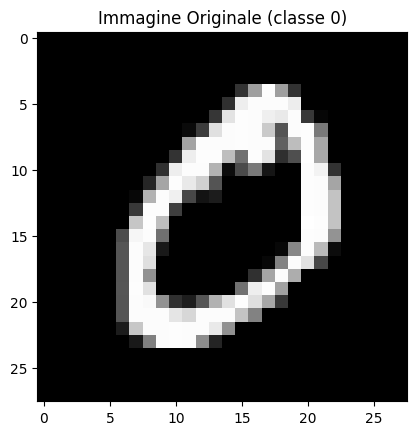

Vettore delle feature (non normalizzato) per la cifra 0: [0.         0.25209391 0.1288792  0.12994432 0.24110384 0.2805132
 0.13812636 0.30365527 0.03113048]


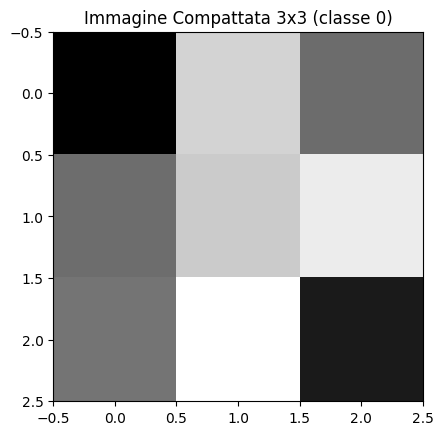

Vettore delle feature (normalizzato) per la cifra 0:
 [0.         0.79197638 0.40488596 0.40823214 0.75745006 0.8812582
 0.43393675 0.95396116 0.09779927]


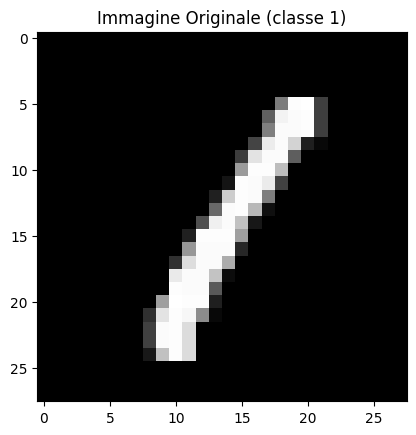

Vettore delle feature (non normalizzato) per la cifra 1: [0.         0.0255144  0.13667394 0.         0.35129508 0.02904866
 0.00968289 0.27736625 0.        ]


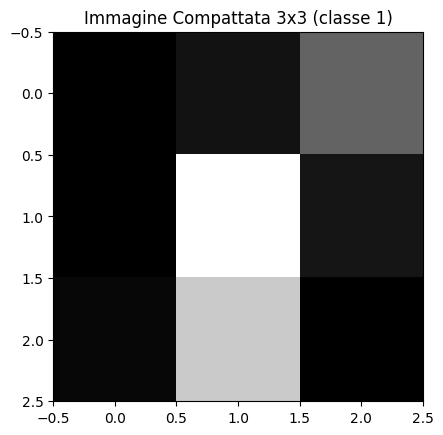

Vettore delle feature (normalizzato) per la cifra 1:
 [0.         0.08015586 0.42937385 0.         1.10362605 0.09125905
 0.03041968 0.87137178 0.        ]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Filtriamo i dati per includere solo le etichette 0 e 1
train_filter = np.where((y_train == 0) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))

X_train_filtered, y_train_filtered = X_train[train_filter], y_train[train_filter]
X_test_filtered, y_test_filtered = X_test[test_filter], y_test[test_filter]


# Definiamo la dimensione del sottoinsieme
subset_size_train = 300
subset_size_test = 120

np.random.seed(42) # Per riproducibilità

subset_size_train = min(subset_size_train, len(X_train_filtered))
subset_size_test = min(subset_size_test, len(X_test_filtered))


train_indices = np.random.choice(len(X_train_filtered), subset_size_train, replace=False)
test_indices = np.random.choice(len(X_test_filtered), subset_size_test, replace=False)

X_train_subset = X_train_filtered[train_indices]
y_train_subset = y_train_filtered[train_indices]

X_test_subset = X_test_filtered[test_indices]
y_test_subset = y_test_filtered[test_indices]


index_0 = np.where(y_train_filtered == 0)[0][0]
index_1 = np.where(y_train_filtered == 1)[0][0]

# Funzione per visualizzare, ridurre e stampare le feature
def process_image(index):
    image = X_train_filtered[index].astype(np.float32) / 255.0
    label = y_train_filtered[index]

    plt.imshow(image, cmap='gray')
    plt.title(f"Immagine Originale (classe {label})")
    plt.show()

    block_size = 28 // 3
    reduced_image = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            block_i_end = min((i+1)*block_size, 28)
            block_j_end = min((j+1)*block_size, 28)
            block = image[i*block_size:block_i_end, j*block_size:block_j_end]
            reduced_image[i, j] = block.mean() if block.size > 0 else 0

    flattened_image = reduced_image.flatten()
    print(f"Vettore delle feature (non normalizzato) per la cifra {label}:", flattened_image)

    plt.imshow(reduced_image, cmap='gray')
    plt.title(f"Immagine Compattata 3x3 (classe {label})")
    plt.show()

    normalized_features = flattened_image * np.pi
    print(f"Vettore delle feature (normalizzato) per la cifra {label}:\n", normalized_features)

process_image(index_0)

process_image(index_1)

Il processo di riduzione ha compresso l'informazione contenuta in un'immagine MNIST di dimensione 28x28 in una rappresentazione molto più compatta, cioè una matrice 3x3. Questo, come detto, è particolarmente utile in contesti in cui è necessario lavorare con poche features, come nella computazione quantistica, dove le risorse (come i qubit) sono limitate.  
Abbiamo selezionato un'immagine dal datest (in particolare quella di uno 0) e normalizzato i suoi valori di pixel in modo che siano compresi tra 0 e 1. Questo si ottiene dividendo ogni valore per 255, dato che i pixel originali vanno da 0 a 255. L'immagine 28x28 viene poi divisa in una griglia 3x3, quindi in 9 blocchi. Ogni blocco copre un’area approssimativa di 9x9 pixel. Poiché 28 non è perfettamente divisibile per 3, la divisione non è esatta, ma viene gestita in modo tale da coprire comunque tutta l'immagine. Per ogni blocco 9x9, si calcola il valore medio dei pixel. I 9 valori medi formano la nuova immagine ridotta. Abbiamo scelto 0 e 1 poirché, ridotti, si nota la differenza di pixel evidenziati dallo 0 (quelli più esterni) e queli evidenziati dall'1 (quelli centrali).

# Addestramento di due modelli classici: SVC e Random Forest

Per prima cosa, appiattiamo i dati di input: ovvero trasformiamo ogni immagine in un vettore unidimensionale.  
Le immagini sono spesso rappresentate come array 3D (in questo caso di 28x28 pixel, o 28x28x3 se RGB), mentre i modelli successivamente addestrati, SVC e RF, si aspettano dati tabellari, input 2D di forma (n_campionamenti, n_caratteristiche).

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#Appiattiamo i dati del sottoinsieme
X_train_flat = X_train_subset.reshape(X_train_subset.shape[0], -1)
X_test_flat = X_test_subset.reshape(X_test_subset.shape[0], -1)

#Creazione e addestramento di un modello SVC sul sottoinsieme
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train_flat, y_train_subset)

#Previsioni sui dati di test del sottoinsieme
y_pred = svm_model.predict(X_test_flat)

#Valutazione modello sul sottoinsieme
accuracy = accuracy_score(y_test_subset, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#Creazione e addestramento di un modello Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train_subset)

#Previsioni sui dati di test
y_pred_rf = rf_model.predict(X_test_flat)

#Valutazione modello
accuracy_rf = accuracy_score(y_test_subset, y_pred_rf)
print(f"Accuracy (Random Forest): {accuracy_rf}")

Accuracy (Random Forest): 1.0


# Riduzione delle features, addestramento SVC e RF sui dati compattati

Addestriamo ora i due stessi modelli con i dati compattati, valutando l'accuracy e concentrandoci sui risultati ottenuti con il Random Forest.

In [ ]:
def compact_image(image):
    """Applica la compattazione 3x3 a una singola immagine."""
    block_size = 28 // 3
    reduced_image = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):

            block_i_end = min((i+1)*block_size, 28)
            block_j_end = min((j+1)*block_size, 28)
            block = image[i*block_size:block_i_end, j*block_size:block_j_end]

            if block.size > 0:
                 reduced_image[i, j] = block.mean()
            else:
                 reduced_image[i, j] = 0
    return reduced_image

#La compattazione è applicata a tutti i dati di addestramento e test
X_train_compacted = np.array([compact_image(img) for img in X_train_subset])
X_test_compacted = np.array([compact_image(img) for img in X_test_subset])

#Appiattiamo i dati compattati
X_train_compacted_flat = X_train_compacted.reshape(X_train_compacted.shape[0], -1)
X_test_compacted_flat = X_test_compacted.reshape(X_test_compacted.shape[0], -1)

#Creazione e addestramento di un modello SVM sui dati compattati
svm_model_compacted = SVC(kernel='linear', C=1)
svm_model_compacted.fit(X_train_compacted_flat, y_train_subset)

#Previsioni sui dati di test compattati
y_pred_compacted = svm_model_compacted.predict(X_test_compacted_flat)

# Valuta il modello
accuracy_compacted = accuracy_score(y_test_subset, y_pred_compacted)
print(f"Accuracy (SVM on compacted data): {accuracy_compacted}")

Accuracy (SVM on compacted data): 1.0


In [ ]:
#Creazione e addestramento di un modello Random Forest sui dati compattati
rf_model_compacted = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_compacted.fit(X_train_compacted_flat, y_train_subset)

#Previsioni sui dati di test compattati
y_pred_rf_compacted = rf_model_compacted.predict(X_test_compacted_flat)

#Valutazione il modello
accuracy_rf_compacted = accuracy_score(y_test_subset, y_pred_rf_compacted)
print(f"Accuracy (Random Forest on compacted data): {accuracy_rf_compacted}")

Accuracy (Random Forest on compacted data): 1.0


## Valutazione del Random Forest su dati compattati

Visualizziamo ora l'importanza delle caratteristiche per capire quali parti dell’immagine compattata influenzano di più le decisioni del modello Random Forest. Questo ci aiuta a interpretare meglio il comportamento del modello, anche visivamente.

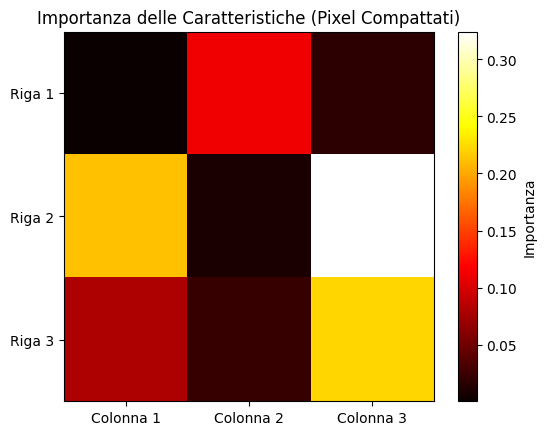

In [ ]:
#Ottieniamo ora l'importanza delle caratteristiche
feature_importances = rf_model_compacted.feature_importances_

#Rimodelliamo l'importanza delle caratteristiche in una matrice 3x3
importance_matrix = feature_importances.reshape((3, 3))

#Visualizziamo l'importanza delle caratteristiche come una heatmap. Qui ogni "quadrato" rappresenta un blocco,
#e il colore indica quanto è rilevante quel blocco per il modello.
#Più è bianco, più è importante.
plt.imshow(importance_matrix, cmap='hot', interpolation='nearest')
plt.title('Importanza delle Caratteristiche (Pixel Compattati)')
plt.colorbar(label='Importanza')
plt.xticks(np.arange(3), ['Colonna 1', 'Colonna 2', 'Colonna 3'])
plt.yticks(np.arange(3), ['Riga 1', 'Riga 2', 'Riga 3'])
plt.show()

La matrice mostra come il modello si concentra molto sul pixel bianco sul bordo. Evidentemente nella maggior parte dei casi è stato il pixel che ha contribuito maggiormente alla classificazione: quando era evidenziato allora era uno 0, quando non lo era, viceversa, era un 1.  
Nella confusion matrix sottostante, invece, notiamo come, anche con i dati compattati, il modello non sbagli mai nella classificazione.

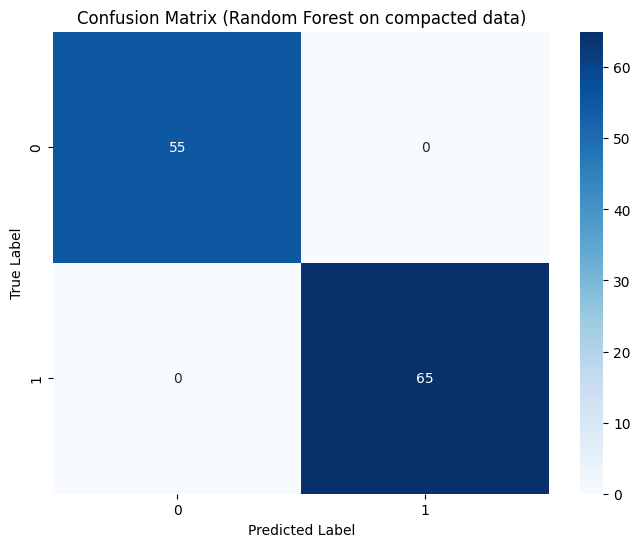

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Calcoliamo, infine, la matrice di confusione per il Random Forest con dati compattati
cm_rf_compacted = confusion_matrix(y_test_subset, y_pred_rf_compacted)

#Visualizza la matrice di confusione come heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_compacted, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest on compacted data)')
plt.show()

# Variational Quantum Classifier


I classificatori quantistici rappresentano un'evoluzione dei modelli classici, sfruttando le proprietà della meccanica quantistica per migliorare prestazioni e accuratezza. L'elemento chiave nella meccanica quantistica è il Qubit, che ci permette di codificare informazioni in sovrapposizione (0 e 1 simultaneamente), permettendo l'elaborazione parallela di stati multipli.  
In un circuto quantistico, la prima cosa da fare è scegliere l'ansatz giusto da utilizzare. Un ansatz è un circuto parametrizzato usato per modellare la funzione di decisione. L'ansatz è costituito da una sequenza di porte quantistiche con parametri variabili (angoli di rotazione, ad esempio), che trasformano lo stato iniziale in uno stato finale |ψ(θ)⟩, dove θ rappresenta il vettore dei parametri da ottimizzare.

L'obiettivo del progetto è costruire un VQC che, dato un input (nel nostro caso un'immagine 3x3), sia in grado distinguere tra le cifre 0 e 1.  
L'idea di base è:

*   codificare i dati (pixel nel nostro caso) in uno stato quantistico;
*   applicare un circuito parametrizzato (ansatz);
*   misurare il risultato;
*   decidere a quale classe appartiene l'immagine (0 o 1).

La differenza principale tra un classificatore classico e uno quantistico sta nella misura: i classificatori classici considerano i pesi e i valori degli input per valutare la funzione di attivazione y=w⋅x+b, tale che se y>soglia allora viene classificato come 0 (o 1), altrimenti come 1 (o 0). I classificatori quantistici invece codificano i dati di input in qubit e dalla misura si ottiene una probabilità, tale che se la probabilità è alta per |1⟩ allora abbiamo uno 0 (o 1), se è alta per |0⟩ viceversa.  
Un'altra differenza tra un classificatore quantistico e classico sta nell'impossibilità di utilizzare in quello quantistico la backpropagation, poiché essa necessita del calcolo del gradiente che causa il collasso dello stato intermedio quantistico in uno stato base.

## Creazione Primo Circuito

L'obiettivo è costruire un ansatz parametrizzato in modo da aggiungere non linearità, correlazione tra i qubit e che ci permetta di addestrare il modello ottimizzando i parametri. La scelta delle operazioni nell'ansatz si basa sull'espressività del circuito (che sia capace di gestire modelli non lineari e interazioni tra feature), un giusto numero di parametri, in base all'hardware disponibile e a quanto visto in letteratura.  
Si può scegliere qualunque combinazione di gate unitari, ma è importante che questi siano espressivi e non troppo difficili da ottimizzare. Di conseguenza usare gate fissi non è efficace ai fini dell'allenamento. Perciò è imporante scegliere combinazioni di gate che rendono il circuito il più espressivo possibile, combinando rotazioni diverse e aggiungendo entanglement tra i qubit.  
L'entanglement rappresenta uno dei principali vantaggi di un VQC rispetto ai modelli classici: crea correlazioni tra feature non ottenibili tramite modelli classici, di conseguenza aumenta l'espressività e può contribuire a ridurre la complessità computazionale.   


(300, 3, 3)


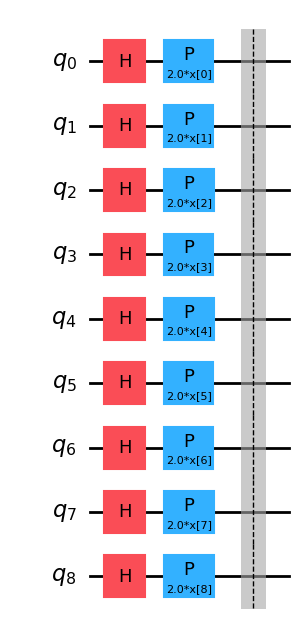

In [ ]:
#Codifichiamo ora i valori negli stati di 9 qubit
from qiskit.circuit.library import ZFeatureMap

print(X_train_compacted.shape)
num_features = X_train_compacted.shape[1]*X_train_compacted.shape[2]


feature_map = ZFeatureMap(feature_dimension=num_features, reps=1) #mappa classica → quantistica usando solo rotazioni Z (feature map semplice).

#codifica ogni feature classica come rotazione attorno all'asse Z su un qubit
feature_map.barrier()
feature_map.decompose().draw(output="mpl", fold=20)

ZFeatureMap è una classe di Qiskit utilizzata per codificare dati classici in uno stato quantistico tramite una mappatura parametrica.  
Il circuito generato da ZFeatureMap applica ad ogni qubit una porta Hadamard e una rotazione parametrica attorno all'asse Z. Ogni qubit riceve la stessa sequenza; non sono presenti porte di entanglement, quindi il circuito è composto solo da operazioni locali sui singoli qubit.

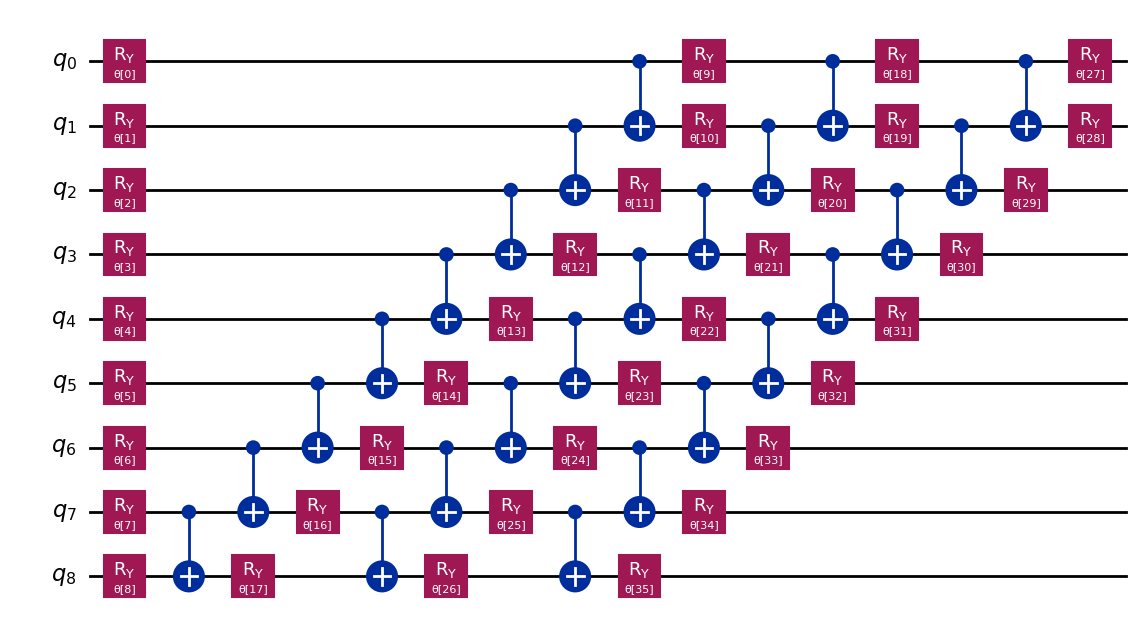

In [ ]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)


Il circuito RealAmplitudes è costruito alternando per un numero di volte specificato (in questo caso 3):
* Layer di rotazioni: ogni qubit riceve una rotazione attorno all’asse Y (porta RY) parametrizzata da un angolo libero (θ).
* Layer di entanglement: vengono applicate porte di entanglement (CNOT) tra coppie di qubit.  

Questa configurazione consente al circuito di esplorare efficacemente lo spazio dei parametri mentre mantiene una complessità gestibile per l'ottimizzazione variazionale.

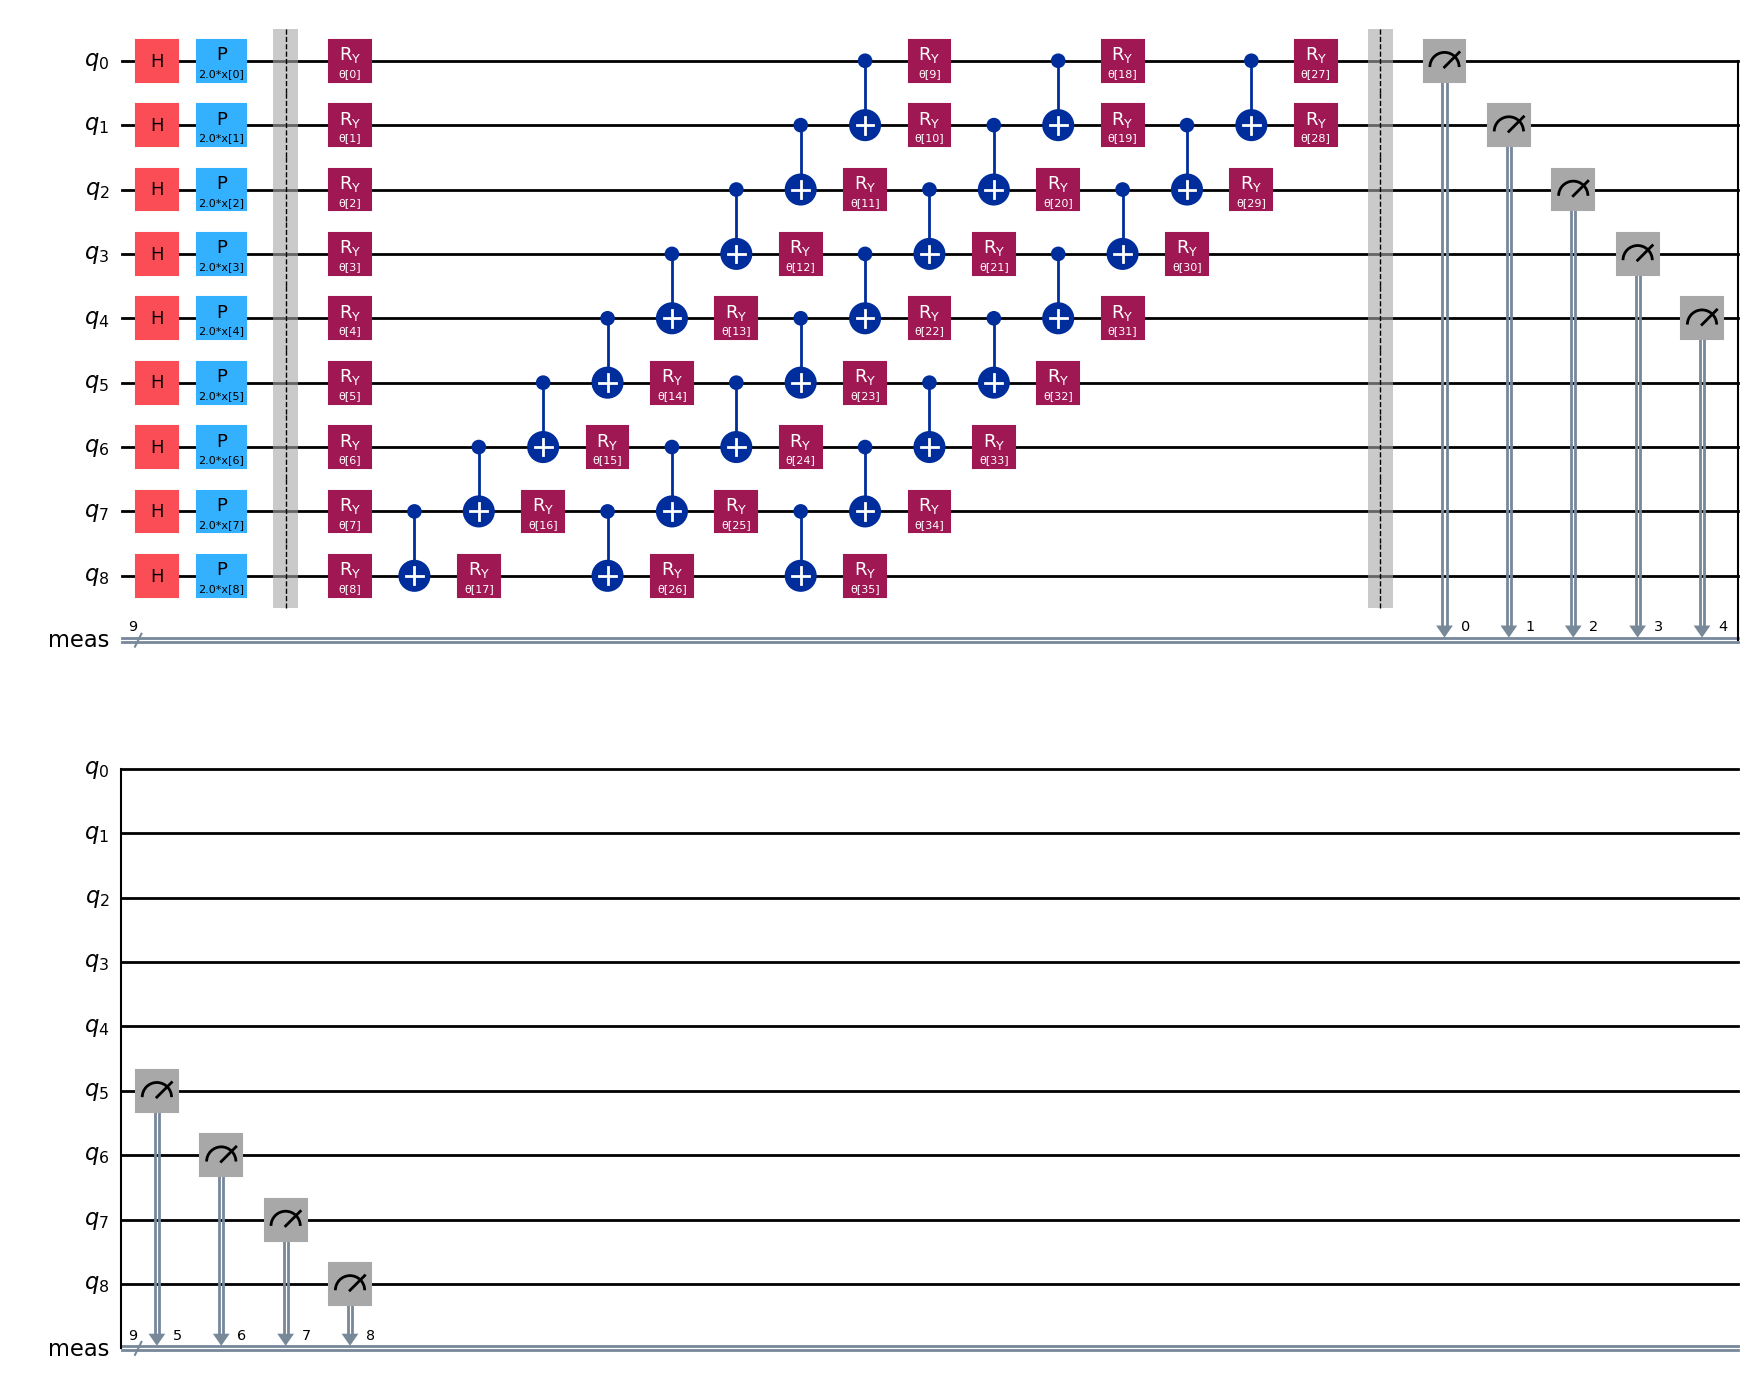

In [ ]:
z_circuit=feature_map.compose(ansatz)
z_circuit.measure_all()
z_circuit.decompose().draw(output="mpl", style="iqp")

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

history=[]
def init_history():
    history.clear()


objective_func_vals = []
def init_graph():
    plt.rcParams["figure.figsize"] = (12, 6)
    objective_func_vals = []
    clear_output(wait=True)


def callback_graph(obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

A seguire definiamo le funzioni principali per il Classificatore Quantistico Variazionale. Gestiamo la creazione e l'esecuzione dei circuiti quantistici, l'interpretazione dei risultati e il calcolo della funzione di costo utilizzata durante il processo di ottimizzazione.  
`log_loss` è importata da sklearn.metrics per valutare le prestazioni del classificatore.  
La `log_loss` misura quanto le probabilità predette dal modello si discostano dalle etichette vere.
* Se la probabilità predetta per la classe corretta è alta (vicina a 1), la log_loss è bassa. Questo significa che il modello è abbastanza sicuro della sua previsione ed è corretto.
* Se la probabilità predetta per la classe corretta è bassa (vicina a 0), la log_loss è alta. Questo significa che il modello è insicuro o ha fatto una previsione sbagliata.  

```
log_loss=−(y⋅log(p)+(1−y)⋅log(1−p))
```

* y∈{0,1}: etichetta vera (0 o 1)  

* p∈(0,1): probabilità predetta che l’etichetta sia 1

Lo `StatevectorSampler` è uno strumento di Qiskit utilizzato per simulare circuiti quantistici e ottenere i risultati delle misurazioni.  
La funzione `circuit_instance` restituisce il circuito parametrizzato.  
La funzione `interpreter` prende una `bitstring`, che rappresenta il risultato della misurazione dal circuito quantistico. Calcola il peso di Hamming della bitstring (il numero di '1' nella stringa). Questo peso di Hamming viene quindi utilizzato per determinare l'etichetta di classe prevista prendendo il risultato modulo 2.  
La funzione `classification_probability` è responsabile dell'esecuzione dei circuiti quantistici per un dato insieme di punti dati (`data`) e i parametri `variational` correnti.  
La `cost_function` calcola quanto bene stanno funzionando gli attuali parametri `variational`.

In [ ]:
#log_loss equivalente a cross-entropy
from sklearn.metrics import log_loss, accuracy_score
from qiskit.primitives import StatevectorSampler


def circuit_instance(tuple, variational):
    # tuple: una tupla
    # variational: parametri dell'ansatz (theta)
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] =tuple[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = variational[i]
    return z_circuit.assign_parameters(parameters)


def interpreter(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight) % 2



def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = interpreter(bitstring)
        probabilities[label] += counts / shots
    return probabilities




def classification_probability(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    #print(classification)
    return classification


def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost=log_loss(y_true=labels,y_pred=[[p[0],p[1]] for p in classifications])
    history.append(cost)
    callback_graph(cost)
    print(cost)
    return cost


def objective_function(variational):
    return cost_function(train_features, train_labels, variational)

## Ottimizzazione con Cobyla

Scegliere un buon ottimizzaore può fare la differenza!  
Il compito principale dell'ottimizzatore è trovare i valori ottimali dei parametri θ dell'ansatz in modo che il circuito classifichi correttamente i dati. Basandosi sulla funzione di perdita, `log_loss`, l'ottimizzatore aggiorna i parametri e ricalcola la `log_loss` con i nuovi parametri e così via cercando di minimizzarla.  
Noi abbiamo testato diversi ottimizzatori, tra cui cobyla, TNC, SLSQP e L_BFGS_B.  
Cobyla si è dimostrato il migliore tra tutti a livelli di accuracy e tempistiche di esecuzione. Caratteristica principale di Cobyla è che non richiede il calcolo di derivate della funzione obiettivo o dei vincoli, rendendolo adatto a funzioni non differenziabili o complesse.  
L-BFGS-B, SLSQP e TNC tendono a performare peggio di COBYLA nei circuiti quantistici perché richiedono gradienti numerici precisi e un paesaggio della funzione di costo liscio e ben condizionato, condizioni spesso violate nei modelli come RealAmplitude con feature map ZFeatureMap, dove COBYLA risulta più efficace grazie alla sua natura di ottimizzatore derivate-free e alla maggiore robustezza su superfici complesse o con plateau.  
Abbiamo infine deciso di utilizzare, oltre cobyla, L_BFGS_B perché a livello di prestazione era più o meno simile agli altri, ma terminava in tempo ragionevole (1h e 30 min).


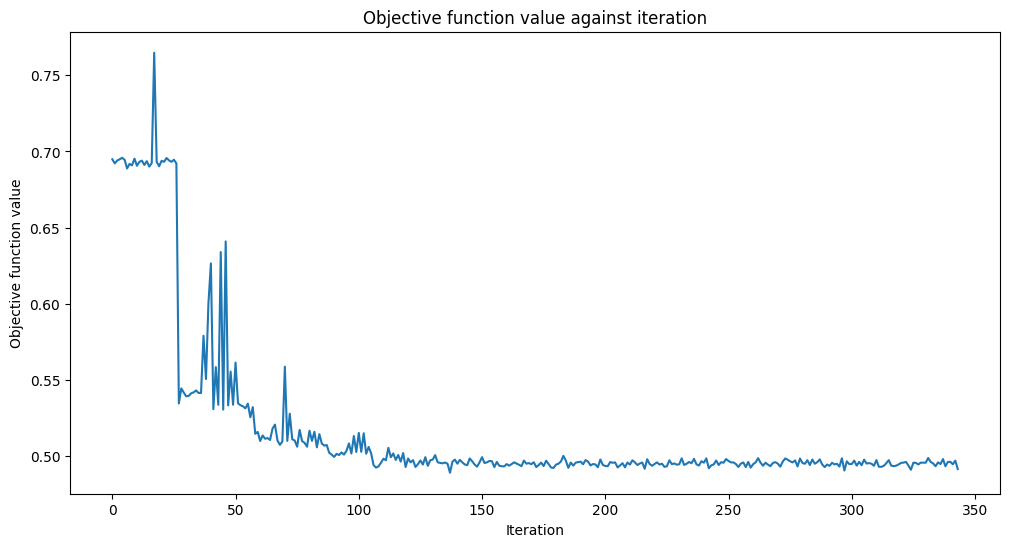

0.49133030616593565


In [ ]:
import numpy as np
from scipy.optimize import minimize

init_history()
init_graph()

# Define train_features and train_labels
train_features = X_train_compacted_flat
train_labels = y_train_subset

initial_point = np.zeros((ansatz.num_parameters))
resZc = minimize(objective_function, initial_point, method="cobyla", options={"maxiter": 500, "maxfev": 2000})

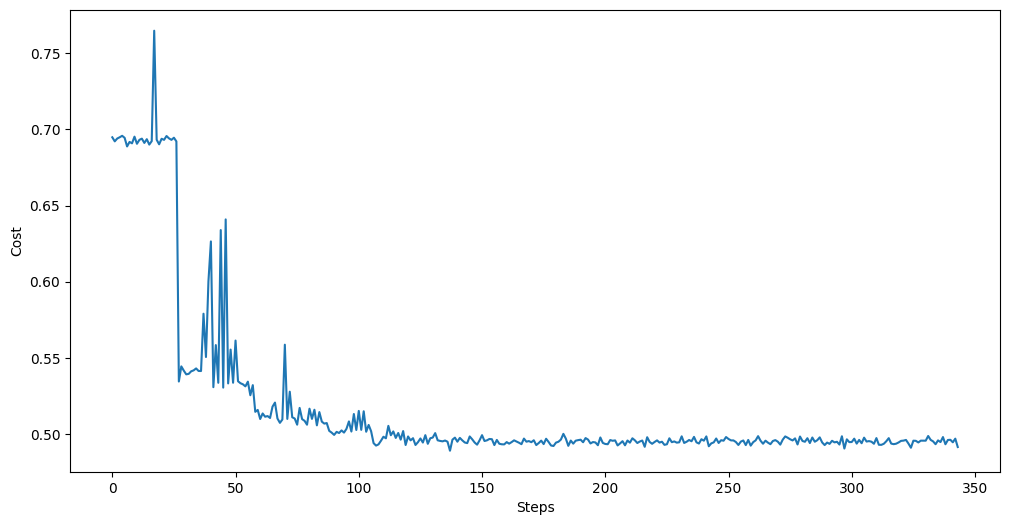

[ 1.26549576e+00 -2.86600456e-01 -1.95278217e-01 -1.11017241e-01
 -5.27458697e-01  8.77117115e-01 -2.64543645e-01 -4.17756801e-02
  3.07578356e-01  3.17195437e-01 -4.80663974e-02  3.25600303e-01
 -1.33076702e-01  3.49612785e-01 -3.94893576e-01 -2.75245294e-01
  1.18552037e-01 -1.63998104e-01 -3.22045982e-01  1.08126092e-01
 -1.53254679e-01  3.87856389e-03 -2.65731659e-01  2.75947567e-02
  6.12646505e-02  7.03505795e-01  9.17631453e-01 -5.72585346e-02
 -1.63023342e-01  1.64010673e-01 -3.64498646e-04 -6.91159428e-02
 -5.44876482e-02 -4.13314570e-02  3.28745901e-01 -4.15198217e-01]
0.49133030616593565


In [ ]:
opt_var = resZc.x # migliori parametri della funzione obiettivo e quindi dell'ansatz
opt_value = resZc.fun # ultima valutazione della funzione obiettivo, nel nostro caso cross-entropy (log_loss)

fig = plt.figure()
plt.plot(history)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

print(opt_var)
print(opt_value)

In [ ]:
def test_classifier(data, labels, variational):
    probability = classification_probability(data, variational)
    #print(probability)
    predictions= [max(p, key=p.get) for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy_trainZc, predictions_train = test_classifier(train_features, train_labels, opt_var)

# Define test_features and test_labels using the pre-processed test data
test_features = X_test_compacted_flat
test_labels = y_test_subset

accuracy_test, predictions_testZc = test_classifier(test_features, test_labels, opt_var)
print(accuracy_trainZc,accuracy_test)

0.7433333333333333 0.6833333333333333


Come ci aspettavamo l'accuracy si presenta inferiore rispetto a quella ottenuta con il classificatore classico. Ciò è dovuto al fatto che i classificatori come SVM, Random Forest o reti neurali classiche sono molto maturi e ottimizzati, a differenza dei modelli quantistici, che sono ancora sperimentali e raramente superano quelli classici su problemi pratici.

In [ ]:
from sklearn.metrics import confusion_matrix
cm_zc = confusion_matrix(y_test_subset,predictions_testZc)
cm_zc


array([[20, 35],
       [ 3, 62]])

## Ottimizzazione con L-BFGS-B

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

history=[]
def init_history():
    history.clear()


objective_func_vals = []
def init_graph():
    plt.rcParams["figure.figsize"] = (12, 6)
    objective_func_vals = []
    clear_output(wait=True)


def callback_graph(obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
#log_loss equivalente a cross-entropy
from sklearn.metrics import log_loss, accuracy_score
from qiskit.primitives import StatevectorSampler


def circuit_instance(tuple, variational):
    # tuple: una tupla
    # variational: parametri dell'ansatz (theta)
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] =tuple[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = variational[i]
    return z_circuit.assign_parameters(parameters)


def interpreter(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight) % 2



def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = interpreter(bitstring)
        probabilities[label] += counts / shots
    return probabilities




def classification_probability(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    #print(classification)
    return classification


def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost=log_loss(y_true=labels,y_pred=[[p[0],p[1]] for p in classifications])
    history.append(cost)
    callback_graph(cost)
    print(cost)
    return cost


def objective_function(variational):
    return cost_function(train_features, train_labels, variational)

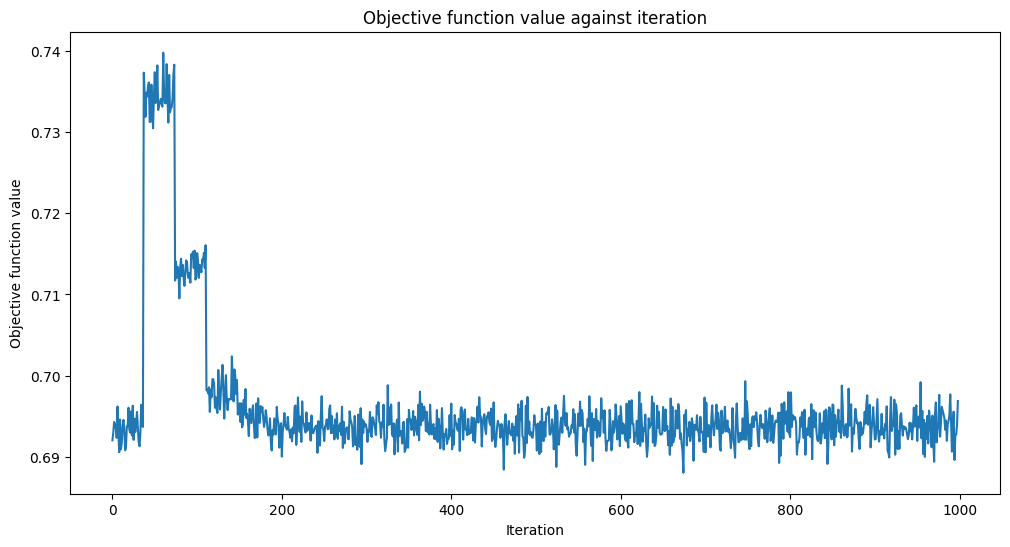

0.6968637409195368
Valore finale della funzione obiettivo (L-BFGS-B): 0.6950231951085167


In [ ]:
import numpy as np
from scipy.optimize import minimize

init_history()
init_graph()

# Define train_features and train_labels
train_features = X_train_compacted_flat
train_labels = y_train_subset

initial_point = np.zeros((ansatz.num_parameters))
# Utilizza l'ottimizzatore TNC (Truncated Newton Conjugate Gradient)
resZs = minimize(objective_function, initial_point, method="L-BFGS-B", options={"maxiter": 300, "maxfev": 600})

print(f"Valore finale della funzione obiettivo (L-BFGS-B): {resZs.fun}")


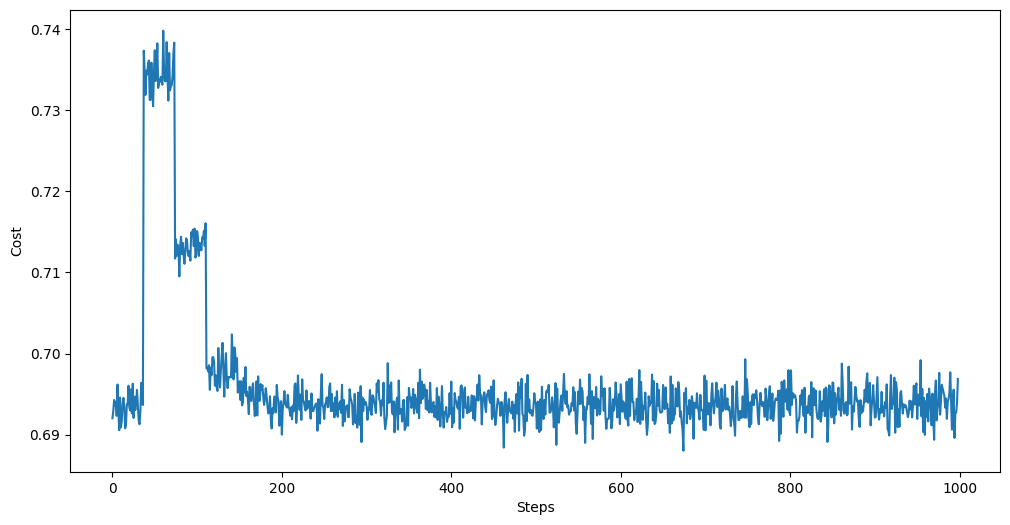

[-3.81965297e-11 -9.54402769e-11 -6.39313232e-11 -8.58864184e-11
 -1.25302463e-11 -1.75924422e-10 -4.69200756e-11  6.20303392e-11
 -1.08045697e-10  4.77307008e-11  1.40277570e-11 -7.22209883e-11
 -1.06384366e-10 -5.81949205e-11  5.22521782e-11  3.68355407e-11
 -7.22382883e-11 -7.22309209e-11 -1.69626124e-10 -5.42002100e-11
 -3.99368832e-11 -1.50403215e-10 -2.54010423e-11 -1.80283221e-10
 -2.32553094e-12 -1.12423978e-10 -4.26456299e-11 -9.12192603e-11
 -1.47759686e-10 -7.26602160e-11  1.02540714e-11  3.10049229e-11
 -3.72619921e-11 -1.85161076e-10 -8.29999183e-11 -6.95484321e-11]
0.6950231951085167


In [ ]:
opt_varT = resZs.x # migliori parametri della funzione obiettivo e quindi dell'ansatz
opt_valueT = resZs.fun # ultima valutazione della funzione obiettivo, nel nostro caso cross-entropy (log_loss)

fig = plt.figure()
plt.plot(history)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

print(opt_varT)
print(opt_valueT)

In [ ]:
def test_classifier(data, labels, variational):
    probability = classification_probability(data, variational)
    #print(probability)
    predictions= [max(p, key=p.get) for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy_trainZs, predictions_train = test_classifier(train_features, train_labels, opt_varT)

# Define test_features and test_labels using the pre-processed test data
test_features = X_test_compacted_flat
test_labels = y_test_subset

accuracy_test, predictions_testZs = test_classifier(test_features, test_labels, opt_varT)
print(accuracy_trainZs,accuracy_test)

0.5033333333333333 0.475


L'ottimizzatore si presenta meno portato ad ottimizzare parametri del nostro dataset. Il risultato è un'accuracy più bassa di quella ottenuta precedentemente.

In [ ]:
from sklearn.metrics import confusion_matrix
cm_zs  = confusion_matrix(y_test_subset,predictions_testZs)
cm_zs


array([[29, 26],
       [37, 28]])

## Creazione Secondo Circuito


La ZFeatureMap codifica le feature classiche come rotazioni attorno all’asse Z senza generare entanglement, risultando semplice ma spesso meno espressiva, mentre la codifica RY applica rotazioni attorno all’asse Y, influenzando direttamente le ampiezze dello stato quantistico e offrendo una rappresentazione più ricca e adatta a modelli che non usano feature map predefinite, specialmente quando combinata con entanglement o circuiti variazionali più profondi.

In [ ]:
from qiskit.circuit import QuantumCircuit, ParameterVector

num_qubits = num_features
ry_params = ParameterVector('x', num_qubits)

ryEncode = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    ryEncode.ry(ry_params[i], i)
ryEncode.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=9, num_clbits=0, params=[]), qubits=(<Qubit register=(9, "q"), index=0>, <Qubit register=(9, "q"), index=1>, <Qubit register=(9, "q"), index=2>, <Qubit register=(9, "q"), index=3>, <Qubit register=(9, "q"), index=4>, <Qubit register=(9, "q"), index=5>, <Qubit register=(9, "q"), index=6>, <Qubit register=(9, "q"), index=7>, <Qubit register=(9, "q"), index=8>), clbits=())

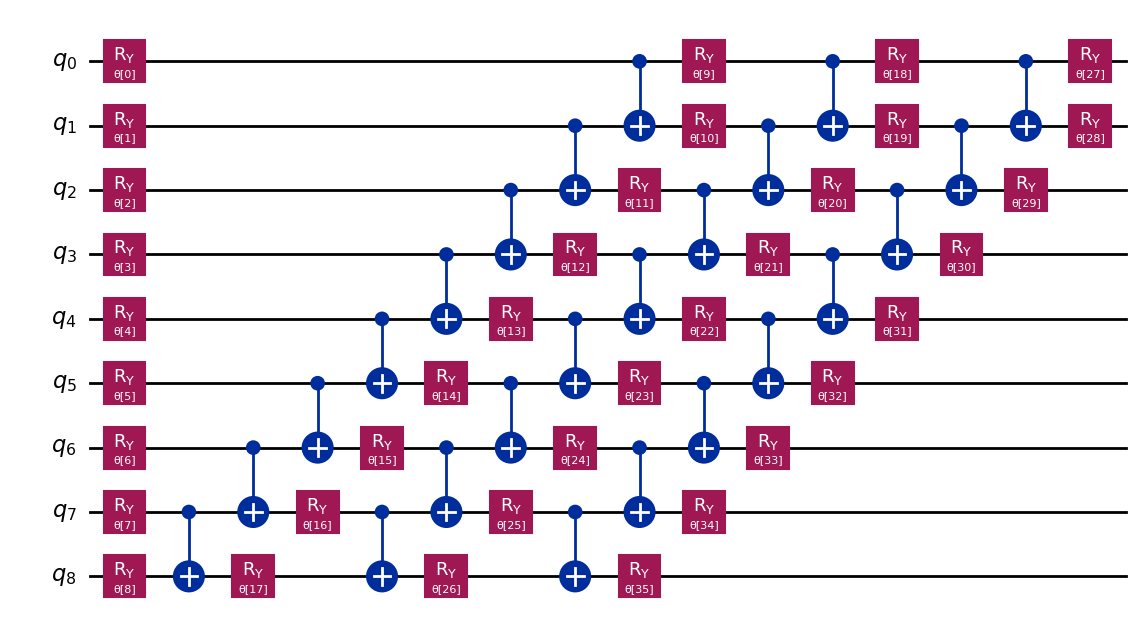

In [ ]:
from qiskit.circuit.library import RealAmplitudes
ansatzRy = RealAmplitudes(num_qubits=num_qubits, reps=3)
ansatzRy.decompose().draw( output="mpl", fold=20)



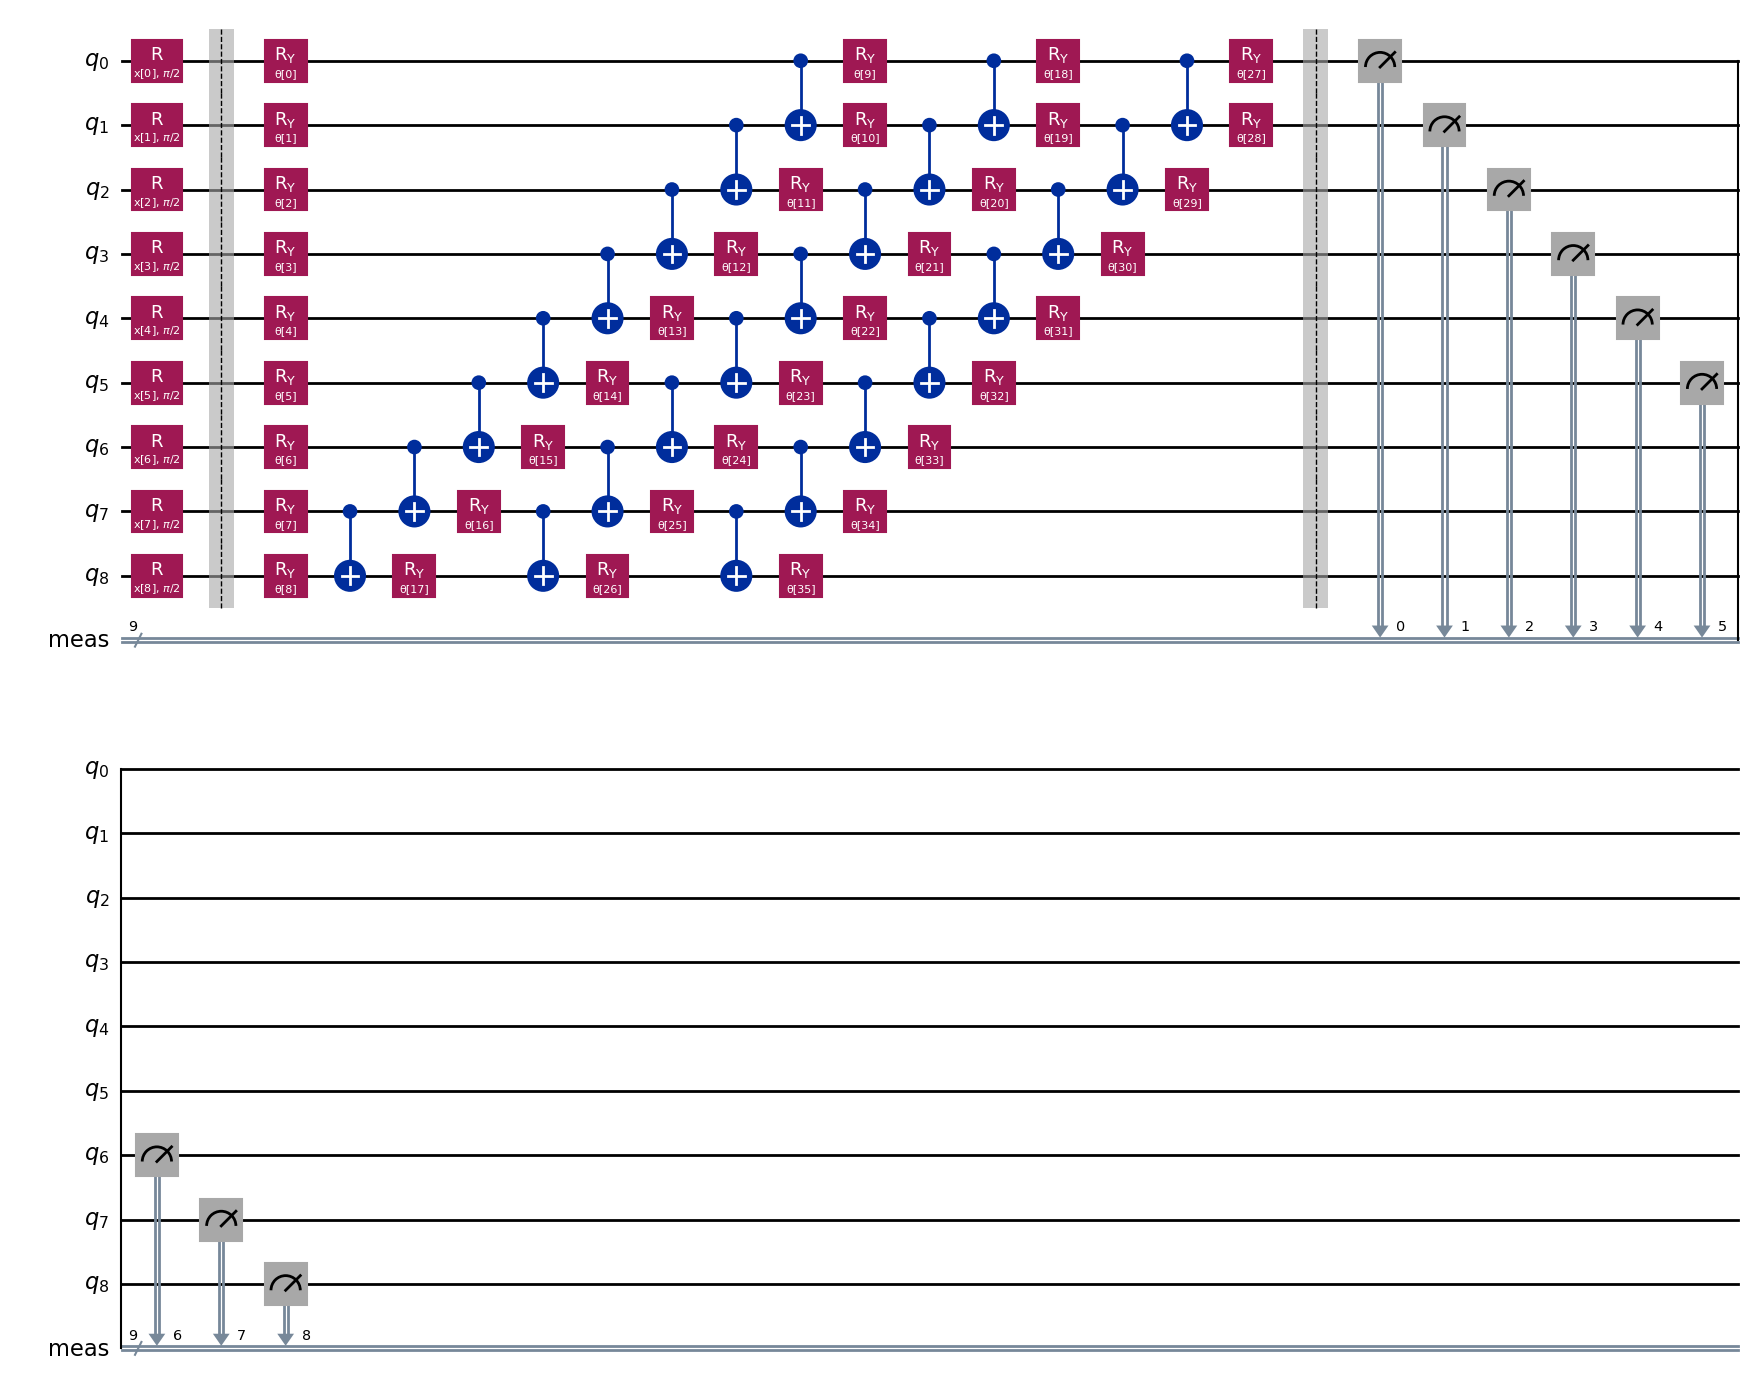

In [ ]:
ry_circuit=ryEncode.compose(ansatzRy)
ry_circuit.measure_all()
ry_circuit.decompose().draw(output="mpl", style="iqp")

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

history=[]
def init_history():
    history.clear()


objective_func_vals = []
def init_graph():
    plt.rcParams["figure.figsize"] = (12, 6)
    objective_func_vals = []
    clear_output(wait=True)


def callback_graph(obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
#log_loss equivalente a cross-entropy
from sklearn.metrics import log_loss, accuracy_score
from qiskit.primitives import StatevectorSampler


def circuit_instance(tupla, variational):
    parameters = {}

    # Associa le feature classiche ai parametri RY della feature map
    for i, p in enumerate(ry_params):
        parameters[p] = tupla[i]

    # Associa i parametri variazionali dell’ansatz
    for i, p in enumerate(ansatzRy.ordered_parameters):
        parameters[p] = variational[i]

    return ry_circuit.assign_parameters(parameters)



def interpreter(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight) % 2



def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = interpreter(bitstring)
        probabilities[label] += counts / shots
    return probabilities




def classification_probability(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    #print(classification)
    return classification


def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost=log_loss(y_true=labels,y_pred=[[p[0],p[1]] for p in classifications])
    history.append(cost)
    callback_graph(cost)
    print(cost)
    return cost


def objective_function(variational):
    return cost_function(train_features, train_labels, variational)

## Ottimizzazione con Cobyla

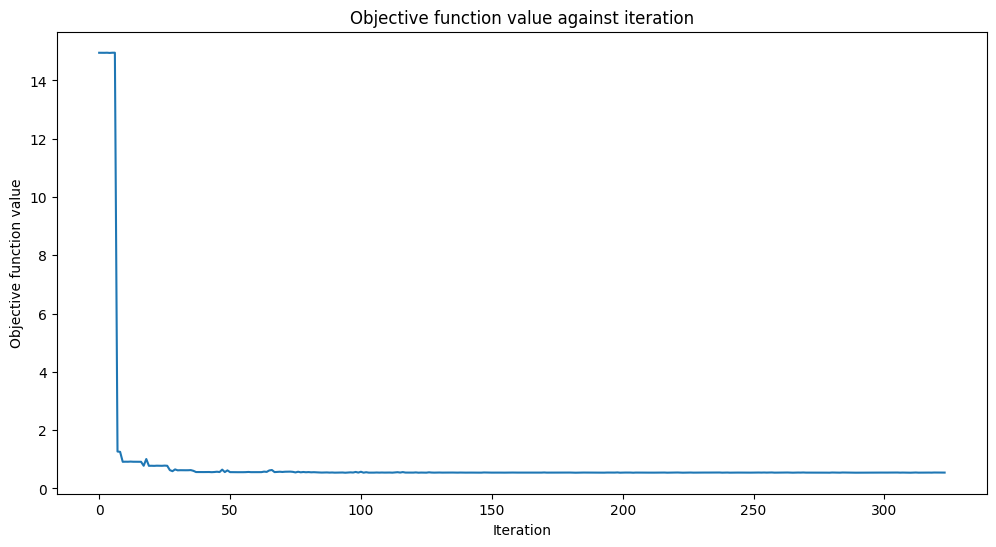

0.5431921572345377


In [ ]:
import numpy as np
from scipy.optimize import minimize

init_history()
init_graph()

# Define train_features and train_labels
train_features = X_train_compacted_flat
train_labels = y_train_subset

initial_point = np.zeros((ansatz.num_parameters))
resRc = minimize(objective_function, initial_point, method="cobyla", options={"maxiter": 500, "maxfev": 2000})

Come si può osservare, la codifica RY parte con errore più alto, perché genera inizialmente uno stato quantistico non strutturato e privo di correlazioni tra i qubit, a differenza della ZFeatureMap che imponeva una struttura regolare e geometrica che rendeva le predizioni iniziali meno casuali.

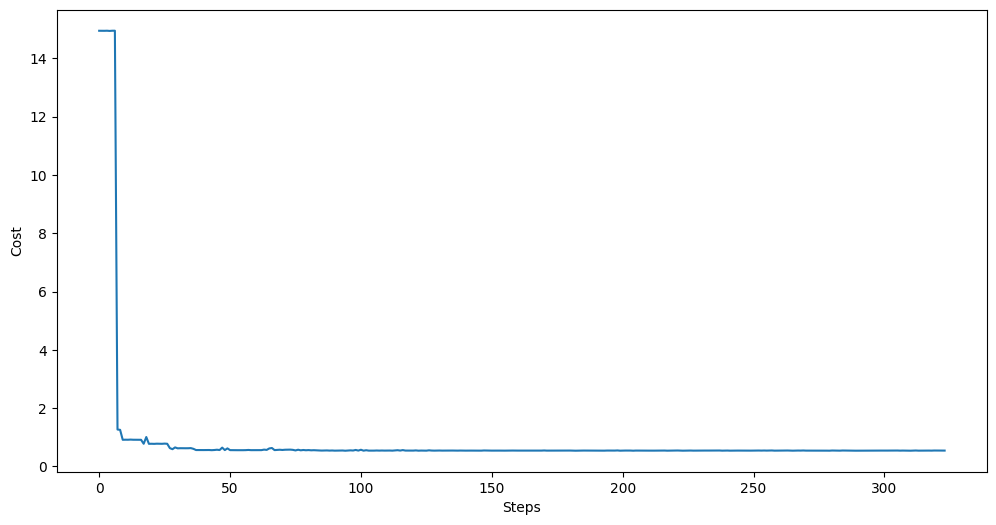

[ 1.38096065  0.99662655  0.26761196  1.55496085  0.54144787 -0.0076788
  1.62714236  1.32278768  1.53048564  0.10121617 -0.54735418 -0.72525462
 -0.07241106 -0.79314054 -0.32444186  0.75291007  1.00300312 -0.28445244
  0.98359651  0.02067791  1.06580222 -0.01050933  0.01383737 -0.01092867
 -0.00883337 -0.04999527  1.37874091  0.74968498 -0.08998803  0.0666995
 -0.20580575  0.18509295  0.09654478 -0.08575475 -0.5015536   0.16121927]
0.5431921572345377


In [ ]:
opt_varRy = resRc.x # migliori parametri della funzione obiettivo e quindi dell'ansatz
opt_valueRy = resRc.fun # ultima valutazione della funzione obiettivo, nel nostro caso cross-entropy (log_loss)

fig = plt.figure()
plt.plot(history)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

print(opt_varRy)
print(opt_valueRy)

In [ ]:
def test_classifier(data, labels, variational):
    probability = classification_probability(data, variational)
    #print(probability)
    predictions= [max(p, key=p.get) for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy_trainRc, predictions_train = test_classifier(train_features, train_labels, opt_varRy)

# Define test_features and test_labels using the pre-processed test data
test_features = X_test_compacted_flat
test_labels = y_test_subset

accuracy_test, predictions_testRc = test_classifier(test_features, test_labels, opt_varRy)
print(accuracy_trainRc,accuracy_test)

0.74 0.7333333333333333


La differenza di prestazioni rispetto al circuito precedente è minima, ma si nota un piccolissimo miglioramento.

In [ ]:
from sklearn.metrics import confusion_matrix
cm_rc = confusion_matrix(y_test_subset,predictions_testRc)
cm_rc

array([[27, 28],
       [ 4, 61]])

## Ottimizzazione con L-BFGS-B

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

history=[]
def init_history():
    history.clear()


objective_func_vals = []
def init_graph():
    plt.rcParams["figure.figsize"] = (12, 6)
    objective_func_vals = []
    clear_output(wait=True)


def callback_graph(obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
#log_loss equivalente a cross-entropy
from sklearn.metrics import log_loss, accuracy_score
from qiskit.primitives import StatevectorSampler


def circuit_instance(tupla, variational):
    parameters = {}

    # Associa le feature classiche ai parametri RY della feature map
    for i, p in enumerate(ry_params):
        parameters[p] = tupla[i]

    # Associa i parametri variazionali dell’ansatz
    for i, p in enumerate(ansatzRy.ordered_parameters):
        parameters[p] = variational[i]

    return ry_circuit.assign_parameters(parameters)



def interpreter(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight) % 2



def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = interpreter(bitstring)
        probabilities[label] += counts / shots
    return probabilities




def classification_probability(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    #print(classification)
    return classification


def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost=log_loss(y_true=labels,y_pred=[[p[0],p[1]] for p in classifications])
    history.append(cost)
    callback_graph(cost)
    print(cost)
    return cost


def objective_function(variational):
    return cost_function(train_features, train_labels, variational)

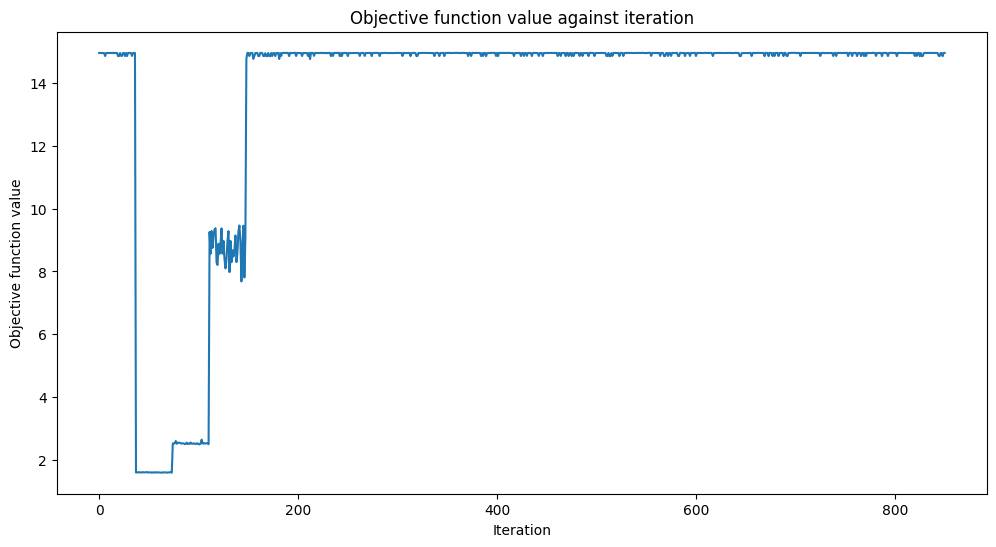

14.94835164031679


In [ ]:
import numpy as np
from scipy.optimize import minimize

init_history()
init_graph()

# Define train_features and train_labels
train_features = X_train_compacted_flat
train_labels = y_train_subset

initial_point = np.zeros((ansatzRy.num_parameters))
resRsp = minimize(objective_function, initial_point, method="L-BFGS-B", options={"maxiter": 300, "maxfev": 600})

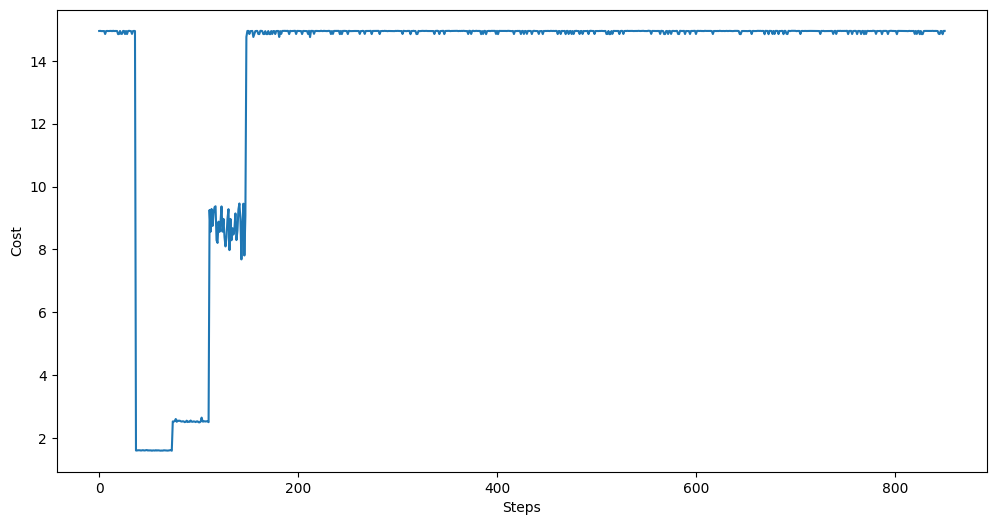

[-3.71517071e-10  3.68180899e-10  3.92448312e-10  5.60214302e-10
  3.08857008e-10  1.05161743e-08  2.41452520e-10 -1.00727623e-10
  2.88453754e-10  1.02393512e-10 -1.01775051e-10 -2.27067549e-10
  6.09793695e-10 -6.52676952e-10  2.99428677e-10  1.09877161e-11
  1.65300126e-10  1.26695384e-10  1.09896537e-08  1.03820315e-08
 -1.21357496e-11  9.96081294e-09  9.82183135e-09  1.40340789e-11
 -6.80476684e-11  1.06205845e-08 -5.65457597e-12  1.06810557e-08
  2.29582425e-10 -5.08898627e-10 -7.71566015e-11  5.77230815e-10
  1.01349486e-08  2.68476467e-10 -1.98239487e-10  1.84013743e-10]
14.946850236683513


In [ ]:
opt_varRsp = resRsp.x # migliori parametri della funzione obiettivo e quindi dell'ansatz
opt_valueRsp = resRsp.fun # ultima valutazione della funzione obiettivo, nel nostro caso cross-entropy (log_loss)

fig = plt.figure()
plt.plot(history)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

print(opt_varRsp)
print(opt_valueRsp)

La combinazione RY + L-BFGS-B mostra una discesa iniziale del log-loss seguita da una risalita e una lunga stagnazione, indicando che l’ottimizzazione ha imboccato una direzione instabile o poco informativa. Questo effetto è dovuto sia alla bassa espressività della feature map RY, che non introduce entanglement, sia alla sensibilità di L-BFGS-B a paesaggi di costo piatti o con minimi locali stretti.

In [ ]:
def test_classifier(data, labels, variational):
    probability = classification_probability(data, variational)
    #print(probability)
    predictions= [max(p, key=p.get) for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy_trainRc, predictions_train = test_classifier(train_features, train_labels, opt_varRsp)

# Define test_features and test_labels using the pre-processed test data
test_features = X_test_compacted_flat
test_labels = y_test_subset

accuracy_test, predictions_testRc = test_classifier(test_features, test_labels, opt_varRsp)
print(accuracy_trainRc,accuracy_test)

0.33666666666666667 0.25833333333333336


In [ ]:
from sklearn.metrics import confusion_matrix
cm_rs = confusion_matrix(y_test_subset,predictions_testRc)
cm_rs

array([[27, 28],
       [61,  4]])

# QCNN


Le reti neurali convoluzionali classiche (CCNN) sono una sottoclasse di reti neurali artificiali in grado di determinare caratteristiche e pattern specifici di un dato input. Per questo motivo, sono comunemente utilizzate nel riconoscimento delle immagini. La capacità di determinare le caratteristiche è il risultato dei due tipi di livelli utilizzati in una CCNN: il livello convoluzionale e il livello di pooling.

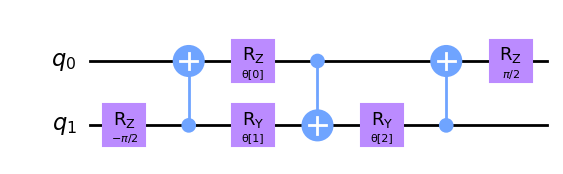

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from sklearn.metrics import log_loss
from qiskit.primitives import StatevectorSampler
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit.circuit.library import ZFeatureMap

# === Z FEATURE MAP ===
feature_map = ZFeatureMap(feature_dimension=9, reps=1)
feature_params = list(feature_map.parameters)


# === CONVOLUTIONAL BLOCK ===
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

La funzione conv_circuit(params) costruisce un blocco convoluzionale quantistico su due qubit. Il circuito esegue una sequenza di:

* rotazioni parametrizzate RY (cambia l'ampiezza delle componenti |0⟩ e |1⟩) e RZ (cambia la fase relativa tra |0⟩ e |1⟩) sui singoli qubit (con parametri params),

* porte CNOT per creare entanglement tra i due qubit.

Queste operazioni combinate permettono al circuito di estrarre caratteristiche complesse dallo stato quantistico, in modo analogo a un filtro convoluzionale nelle reti neurali classiche. I parametri params sono ottimizzati durante l’addestramento per migliorare la capacità di apprendimento della rete quantistica.   
In questo strato convoluzionale quantistico, applichiamo prima il blocco a due qubit a tutte le coppie di qubit con indici pari (cioè qubit 0 e 1, 2 e 3, e così via). Successivamente, applichiamo lo stesso blocco alle coppie di qubit con indici dispari, ma in modo circolare, cioè accoppiando il primo e l'ultimo qubit per chiudere il ciclo. In questo modo, ogni qubit viene accoppiato con i suoi vicini in modo continuo e circolare, garantendo un’interazione completa tra qubit adiacenti all’interno dello strato.

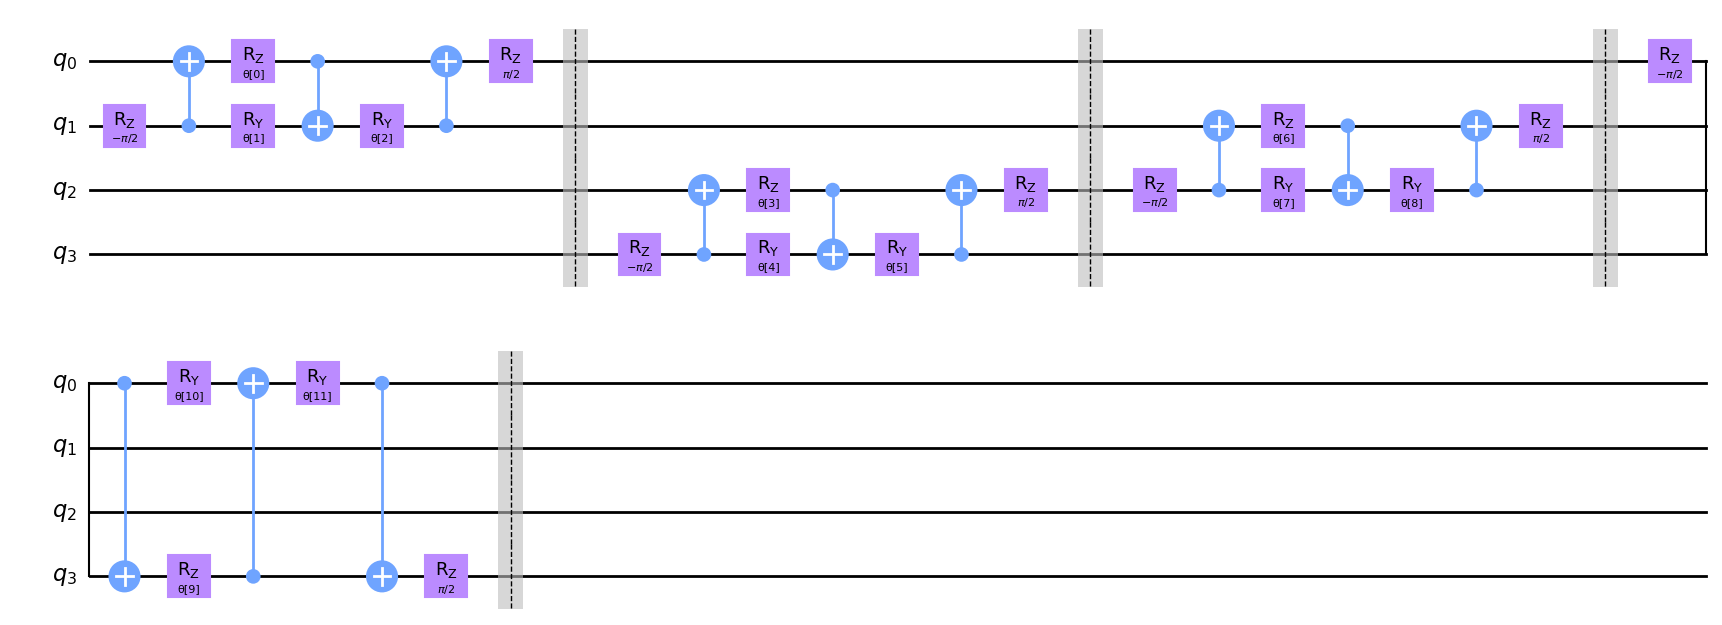

In [ ]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=(len(qubits) * 3))
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc.compose(conv_circuit(params[param_index:param_index + 3]), [q1, q2], inplace=True)
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [qubits[0]]):
        qc.compose(conv_circuit(params[param_index:param_index + 3]), [q1, q2], inplace=True)
        qc.barrier()
        param_index += 3
    qc_inst = qc.to_instruction()
    qc_layer = QuantumCircuit(num_qubits)
    qc_layer.append(qc_inst, range(num_qubits))
    return qc_layer

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")


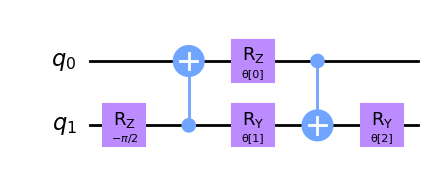

In [ ]:
# === POOLING BLOCK ===
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

Lo scopo di un livello di pooling è ridurre le dimensioni del nostro circuito quantistico, ovvero ridurre il numero di qubit nel circuito, pur mantenendo quante più informazioni possibili dai dati precedentemente appresi. Ridurre il numero di qubit riduce anche il costo computazionale dell'intero circuito, poiché diminuisce il numero di parametri che la QCNN deve apprendere.

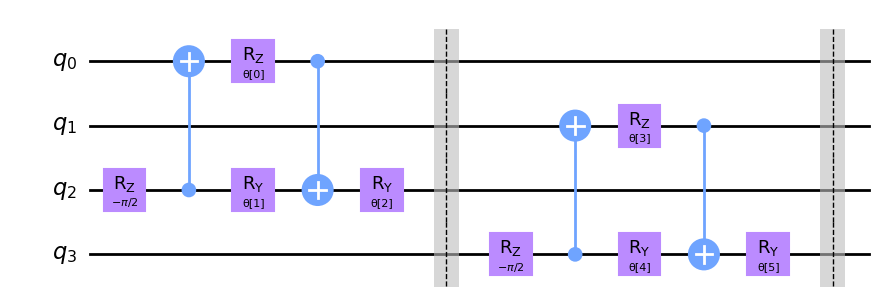

In [ ]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = max(sources + sinks) + 1
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=len(sources) * 3)
    for source, sink in zip(sources, sinks):
        qc.compose(pool_circuit(params[param_index:param_index + 3]), [source, sink], inplace=True)
        qc.barrier()
        param_index += 3
    qc_inst = qc.to_instruction()
    qc_layer = QuantumCircuit(num_qubits)
    qc_layer.append(qc_inst, range(num_qubits))
    return qc_layer

sources = [0, 1] # qubit da "ignorare"
sinks = [2, 3] # qubit che "rimangono attivi"
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")


Dato che non è possibile semplicemente diminuire la quantità di qubit rispetto all'approccio classico, per ridurre "artificialmente" il numero di qubit del nostro circuito iniziamo innanzitutto creando coppie di qubit nel nostro sistema. Successivamente, da ogni coppia, viene selezionato un solo qubit che sarà utilizzato per la classificazione.

In [ ]:
# === QCNN MODEL ===
def qcnn_model():
    num_qubits=9
    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(conv_layer(num_qubits, "θ1"), inplace=True)
    qc.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "θ2"), inplace=True)
    qc.compose(conv_layer(6, "θ3"), inplace=True)
    qc.compose(pool_layer([0, 1, 2], [3, 4, 5], "θ4"), inplace=True)
    qc.compose(conv_layer(4, "θ5"), inplace=True)
    qc.compose(pool_layer([0, 1], [2, 3], "θ6"), inplace=True)
    qc.compose(conv_layer(2, "θ7"), inplace=True)
    qc.compose(pool_layer([0], [1], "θ8"), inplace=True)

    qc.measure_all()
    return qc

ad_hoc_circuit = qcnn_model()

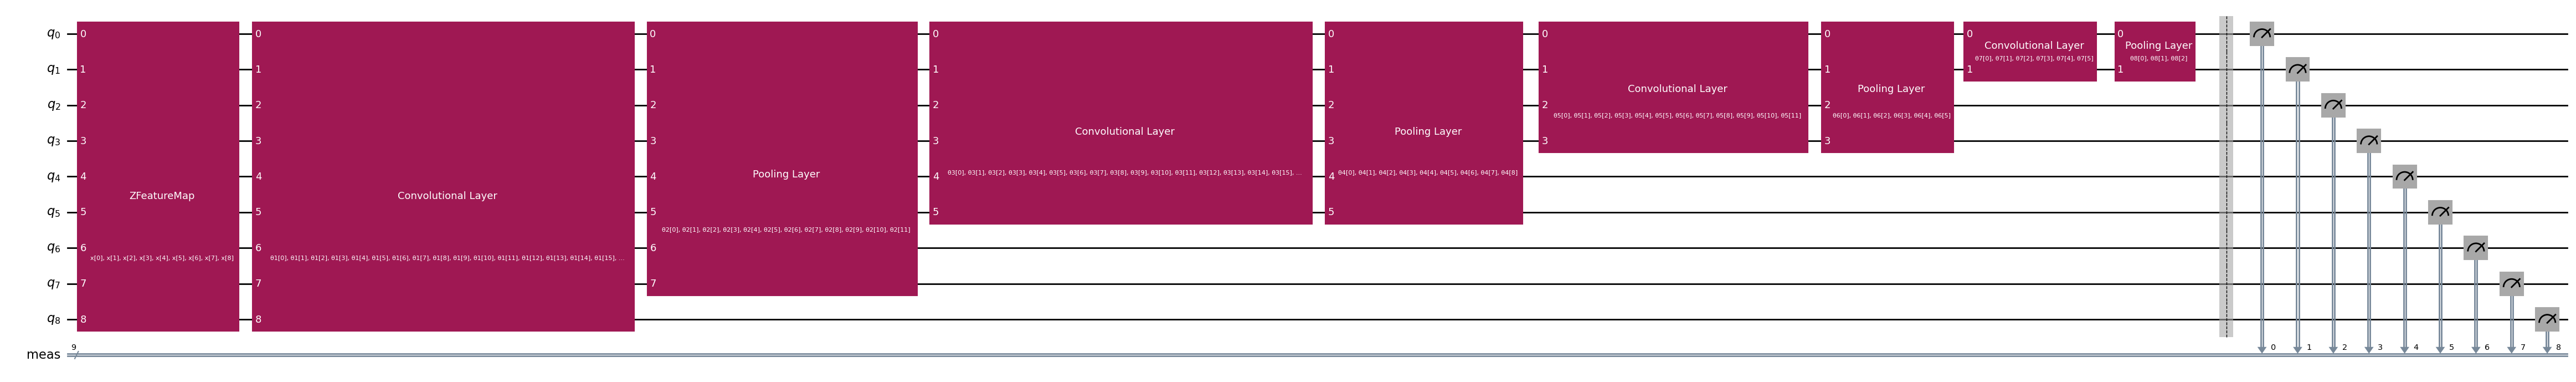

In [ ]:
ad_hoc_circuit.draw(output="mpl", style="iqp", fold=100)

Inizialmente, una mappa delle caratteristiche codifica l’input su tutti i 9 qubit, seguita da una prima convoluzione che coinvolge tutti i qubit. Il primo pooling riduce il numero di qubit attivi escludendo il qubit 8, mantenendo 8 qubit.

Una seconda convoluzione su 8 qubit e un secondo pooling riducono ulteriormente lo spazio, lasciando 6 qubit attivi. Successivamente, terza convoluzione e terzo pooling operano una nuova riduzione a 4 qubit, seguiti da una quarta convoluzione e un ultimo pooling che portano infine a due soli qubit attivi.

La misura finale, eseguita su tutti i qubit per semplicità, si concentra effettivamente sui due qubit finali, che sintetizzano il risultato del modello. Questa struttura permette di replicare un processo di estrazione e compressione delle informazioni tipico delle reti neurali convoluzionali, ma applicato al calcolo quantistico.

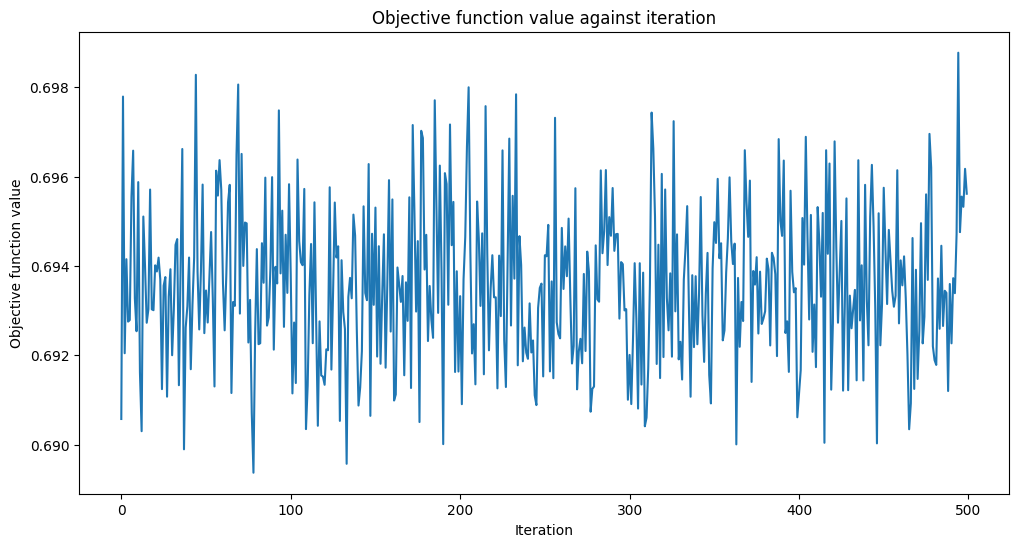

0.6956189162074601


In [ ]:
# === OPTIMIZATION CALLBACK ===
objective_func_vals = []

history=[]
def init_history():
    history.clear()

def init_graph():
    plt.rcParams["figure.figsize"] = (12, 6)
    objective_func_vals.clear()
    clear_output(wait=True)

def callback_graph(obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# === LABELING ===
def interpreter(bitstring):
    return sum(int(k) for k in list(bitstring)) % 2

def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = interpreter(bitstring)
        probabilities[label] += counts / shots
    return probabilities

# === CIRCUIT PARAMETERIZATION ===
def circuit_instance(tuple_data, variational):
    parameters = {}
    var_params = list(ad_hoc_circuit.parameters - set(feature_params))
    for i, p in enumerate(feature_params):
        parameters[p] = tuple_data[i]
    for i, p in enumerate(var_params):
        parameters[p] = variational[i]
    return ad_hoc_circuit.assign_parameters(parameters)

def classification_probability(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, _ in enumerate(circuits)
    ]
    return classification

def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost = log_loss(y_true=labels, y_pred=[[p[0], p[1]] for p in classifications])
    history.append(cost)
    callback_graph(cost)
    print(cost)
    return cost

def objective_function(variational):
    return cost_function(train_features, train_labels, variational)

# === TRAINING ===
from scipy.optimize import minimize

# Inserisci i tuoi dati qui:
train_features = X_train_compacted_flat
train_labels = y_train_subset

init_history()
init_graph()
initial_point = np.zeros(len(ad_hoc_circuit.parameters) - len(feature_params))
res = minimize(objective_function, initial_point, method="cobyla", options={"maxiter": 500, "maxfev": 2000})

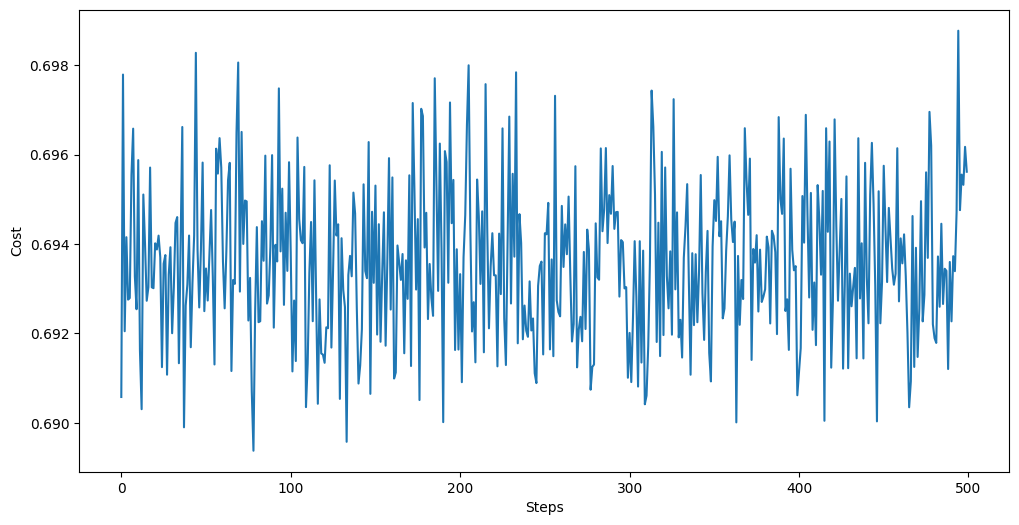

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.6893733164564717


In [ ]:
opt_varQ = res.x # migliori parametri della funzione obiettivo e quindi dell'ansatz
opt_valueQ = res.fun # ultima valutazione della funzione obiettivo, nel nostro caso cross-entropy (log_loss)

fig = plt.figure()
plt.plot(history)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

print(opt_varQ)
print(opt_valueQ)

In [ ]:
def predict_labels(data, variational):
    probs = classification_probability(data, variational)
    predictions = [0 if p[0] > p[1] else 1 for p in probs]
    return predictions

from sklearn.metrics import accuracy_score

# Inserisci il tuo test set qui:
test_features = X_test_compacted_flat
test_labels = y_test_subset

# Ottieni le predizioni
predictions = predict_labels(test_features, res.x)

# Calcola e stampa l'accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.475


In [ ]:
from sklearn.metrics import confusion_matrix
cm_qcnn = confusion_matrix(y_test_subset,predictions)
cm_qcnn

array([[26, 29],
       [34, 31]])

# Confronti finali

Riportiamo, infine, un confronto tra i vari classificatori studiati, mediante la rappresentazione e il confronto di tre indici di prestazione: accuracy, precision e recall.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_matrices = {
    "Modello Classico": cm_rf_compacted,
    "QCNN": cm_qcnn,
    "VQC (ZFeatureMap)": cm_zc,
    "VQC (RY Encoding)": cm_rc
}
metrics = {
    "Modello": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": []
}

for nome, cm in confusion_matrices.items():
    accuracy = np.trace(cm) / np.sum(cm)
    precision = cm[1,1] / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) else 0
    recall = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) else 0

    metrics["Modello"].append(nome)
    metrics["Accuracy"].append(accuracy)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)

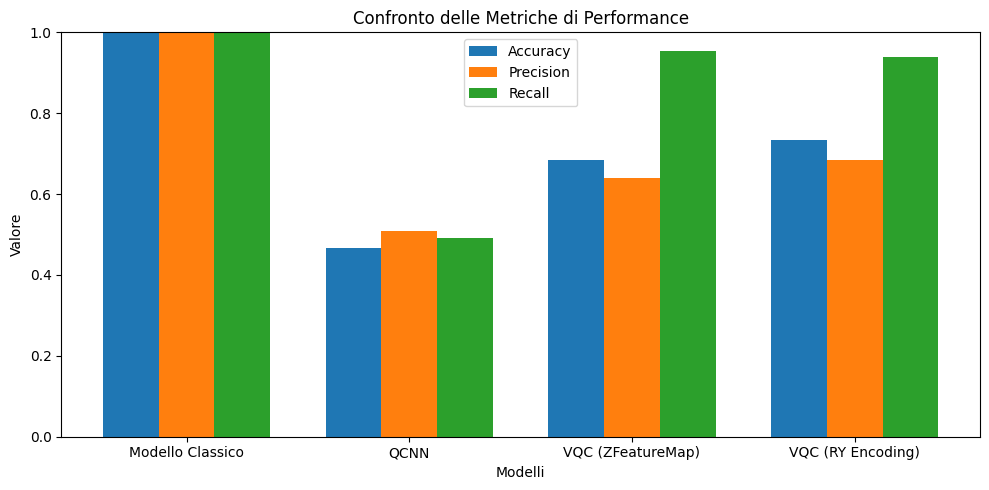

In [ ]:
# Grafico a barre per Accuracy, Precision, Recall
labels = metrics["Modello"]
x = range(len(labels))

plt.figure(figsize=(10, 5))
bar_width = 0.25

plt.bar(x, metrics["Accuracy"], width=bar_width, label='Accuracy')
plt.bar([i + bar_width for i in x], metrics["Precision"], width=bar_width, label='Precision')
plt.bar([i + 2*bar_width for i in x], metrics["Recall"], width=bar_width, label='Recall')

plt.xlabel("Modelli")
plt.ylabel("Valore")
plt.title("Confronto delle Metriche di Performance")
plt.xticks([i + bar_width for i in x], labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Conclusioni

In questo progetto abbiamo confrontato diversi approcci di classificazione su una versione semplificata del dataset MNIST (solo cifre 0 e 1), ridotta a immagini di dimensione 3x3 pixel. Nel confronto finale, analizziamo i grafici rispettivamente di:
*  un modello classico (Random Forest);
*  un VQC con ZFeatureMap e ottimizzazione COBYLA;
*  un VQC con RYFeatureMap e COBYLA;
*  un Quantum Convolutional Neural Network (QCNN), sempre con 9 qubit e ottimizzatore COBYLA.

I risultati ottenuti mostrano come, sorprendentemente, la QCNN — pur essendo teoricamente il modello quantistico più promettente grazie alla sua struttura ispirata alle reti convoluzionali classiche — abbia performato peggio rispetto agli altri approcci, inclusi i VQC più semplici.

Questa discrepanza può essere attribuita a diversi fattori:

- Dimensione estremamente ridotta del dataset e input semplificato (3x3): la QCNN è progettata per trarre vantaggio da pattern locali e gerarchie spaziali nei dati, cosa difficile da sfruttare su immagini così piccole e binarie.

- Rumore e limitazioni della simulazione: la complessità architetturale della QCNN può introdurre maggiore sensibilità al rumore (nel caso di hardware reale) o difficoltà nell'ottimizzazione (in simulazione).

Nonostante le prestazioni inferiori, la QCNN mantiene un grande valore concettuale: rappresenta un ponte tra le tecniche classiche di deep learning e le potenzialità dell’informatica quantistica. La sua struttura modulare e scalabile è potenzialmente molto potente in scenari con input più ricchi e una maggiore disponibilità di qubit o risorse computazionali quantistiche.

Con dataset più strutturati e input di dimensioni maggiori, è lecito aspettarsi che il vantaggio architetturale della QCNN emerga in modo più netto. Inoltre, l’utilizzo di tecniche di ottimizzazione più sofisticate e hardware quantistici più maturi potrebbe valorizzare pienamente le sue potenzialità.